In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt

# Step 1: Download and preprocess the data
ticker = 'EURUSD=X'
data = yf.download(ticker, start='2010-01-01', end='2023-01-01')
data = data[['Close']].copy()  # Ensure we are working with a copy

[*********************100%%**********************]  1 of 1 completed


In [18]:

# Step 2: Feature Engineering
# (Implement Elliott Wave and other features as needed)
data.loc[:, 'Return'] = data['Close'].pct_change()
data.dropna(inplace=True)

In [19]:
# Step 3: Data Preparation
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)

# Step 4: Build LSTM Model
model = Sequential()
model.add(Input(shape=(X.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
# Step 5: Training and Evaluation
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0689 - val_loss: 4.5897e-04
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0052 - val_loss: 3.5096e-04
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0042 - val_loss: 3.4486e-04
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0040 - val_loss: 3.9930e-04
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0036 - val_loss: 3.4383e-04
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0034 - val_loss: 6.2498e-04
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0033 - val_loss: 3.3839e-04
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0035 - val_loss: 3.2652e-04
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0029 - val_loss: 3.2948e-04
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0026 - val_loss: 3.1405e-04
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0029 - val_loss: 3.2066e-04
Epoch 12/50
67/67 ━

In [21]:

# Step 6: Prediction and Visualization
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


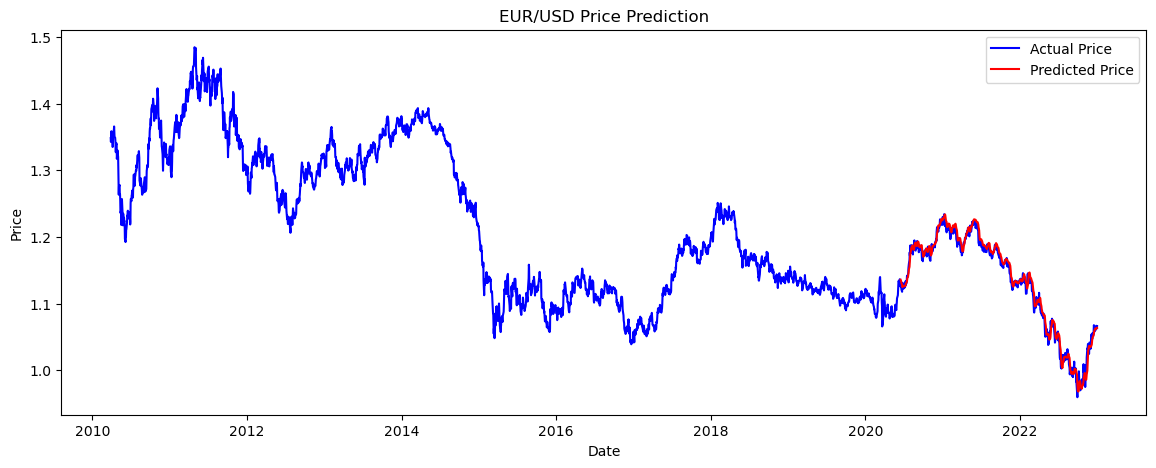

In [22]:
# Correct the indices for plotting
train_data_len = split + sequence_length
test_data_index = data.index[train_data_len:train_data_len + len(predictions)]

plt.figure(figsize=(14,5))
plt.plot(data.index[sequence_length:], data['Close'][sequence_length:], color='blue', label='Actual Price')
plt.plot(test_data_index, predictions, color='red', label='Predicted Price')
plt.title('EUR/USD Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()










In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming `predictions` and `y_test` are already defined
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.1805454660915765
Mean Absolute Error: 0.42352345679935655
R-squared: -33.09196139999328


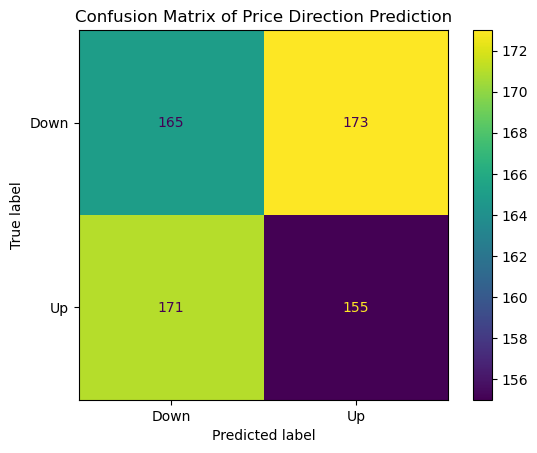

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert the predicted and actual prices into binary classes (up or down)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Determine the direction of the price movement
y_test_direction = np.diff(y_test_actual, axis=0).reshape(-1)
predictions_direction = np.diff(predictions, axis=0).reshape(-1)

# Convert to binary classification: 1 for up, 0 for down
y_test_binary = (y_test_direction > 0).astype(int)
predictions_binary = (predictions_direction > 0).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test_binary, predictions_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot()

plt.title('Confusion Matrix of Price Direction Prediction')
plt.show()
